# Advanced Artificial Intelligence Extra credit project

Lalitha Priya Bijja - 101168225

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time

In [3]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

In [5]:
validation_fraction = 0.1

In [6]:
num = int(validation_fraction * 60000) 
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

In [7]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, drop_last=True, sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# Checking the dataset
for images, labels in train_loader: 
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


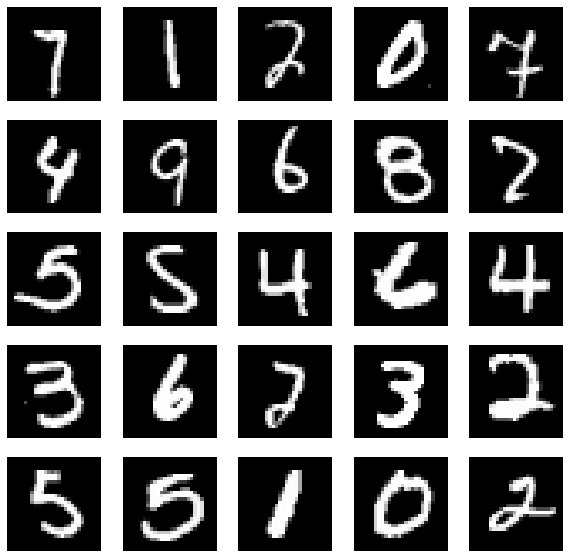

In [10]:
import matplotlib.pyplot as plt
# Display a grid of sample images
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_loader):
    for j in range(25):
        plt.subplot(5, 5, j + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.axis('off')
    break
plt.show()

In [19]:
class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        self.network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            # output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
    def forward(self, x):
        logits = self.network(x)
        return logits

In [20]:
model = MLP(num_features=28*28, num_hidden_1=128, num_hidden_2=64, num_classes=10)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min')

In [21]:
# Define your optimizer (using Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Create the scheduler with step decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [23]:
# Create the scheduler with exponential decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [24]:
def compute_accuracy(data_loader):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(DEVICE)
            targets = targets.float().to(DEVICE)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [25]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        # ## FORWARD AND BACK PROP
        logits = model(features)
        #loss = F.cross_entropy(logits, targets)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        # ## UPDATE MODEL PARAMETERS
        optimizer.step()
        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        logging_interval = 100
        if not batch_idx % logging_interval:
            print("Epoch: ", epoch+1,"/", NUM_EPOCHS,"| Batch ",batch_idx,"/",len(train_loader), f'| Loss: {loss:.4f}')
    model.eval()
    with torch.no_grad(): # save memory during inference
        train_acc = compute_accuracy(train_loader)
        valid_acc = compute_accuracy(valid_loader) 
        print("Epoch: ", epoch+1, "/",NUM_EPOCHS,f'| Train: {train_acc :.2f}% 'f'| Validation: {valid_acc :.2f}%') 
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())
    elapsed = (time.time() - start_time)/60
    print("Time elapsed: ",elapsed, " min")
    scheduler.step(minibatch_loss_list[-1])
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')
test_acc = compute_accuracy(test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.4323
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.6755
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.6165
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.3568
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.3803
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.3633
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.3493
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.2647
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.1504
Epoch:  1 / 20 | Train: 94.62% | Validation: 95.85%
Time elapsed:  0.587981907526652  min
Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.5470


C:\Users\dasar\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.1650
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.1891
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.3242
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.3554
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.3723
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.3108
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.1702
Epoch:  2 / 20 | Batch  800 / 843 | Loss: 0.2652
Epoch:  2 / 20 | Train: 96.05% | Validation: 96.95%
Time elapsed:  1.1883620897928873  min
Epoch:  3 / 20 | Batch  0 / 843 | Loss: 0.2003
Epoch:  3 / 20 | Batch  100 / 843 | Loss: 0.3846
Epoch:  3 / 20 | Batch  200 / 843 | Loss: 0.3138
Epoch:  3 / 20 | Batch  300 / 843 | Loss: 0.0943
Epoch:  3 / 20 | Batch  400 / 843 | Loss: 0.4107
Epoch:  3 / 20 | Batch  500 / 843 | Loss: 0.2487
Epoch:  3 / 20 | Batch  600 / 843 | Loss: 0.1868
Epoch:  3 / 20 | Batch  700 / 843 | Loss: 0.2683
Epoch:  3 / 20 | Batch  800 / 843 | Loss: 0.2047
Epoch:  3 / 20 | Train: 96.92% | Validation: 97.38%
Time elapsed:  1.778187735

Epoch:  17 / 20 | Batch  500 / 843 | Loss: 0.1199
Epoch:  17 / 20 | Batch  600 / 843 | Loss: 0.0718
Epoch:  17 / 20 | Batch  700 / 843 | Loss: 0.2255
Epoch:  17 / 20 | Batch  800 / 843 | Loss: 0.1317
Epoch:  17 / 20 | Train: 98.76% | Validation: 98.17%
Time elapsed:  10.098923075199128  min
Epoch:  18 / 20 | Batch  0 / 843 | Loss: 0.1120
Epoch:  18 / 20 | Batch  100 / 843 | Loss: 0.0918
Epoch:  18 / 20 | Batch  200 / 843 | Loss: 0.1731
Epoch:  18 / 20 | Batch  300 / 843 | Loss: 0.0967
Epoch:  18 / 20 | Batch  400 / 843 | Loss: 0.1971
Epoch:  18 / 20 | Batch  500 / 843 | Loss: 0.0831
Epoch:  18 / 20 | Batch  600 / 843 | Loss: 0.2767
Epoch:  18 / 20 | Batch  700 / 843 | Loss: 0.0666
Epoch:  18 / 20 | Batch  800 / 843 | Loss: 0.2113
Epoch:  18 / 20 | Train: 98.82% | Validation: 98.07%
Time elapsed:  10.685632753372193  min
Epoch:  19 / 20 | Batch  0 / 843 | Loss: 0.0718
Epoch:  19 / 20 | Batch  100 / 843 | Loss: 0.3796
Epoch:  19 / 20 | Batch  200 / 843 | Loss: 0.1030
Epoch:  19 / 20 | Ba

Text(0, 0.5, 'Loss')

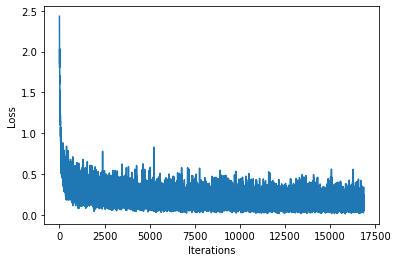

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

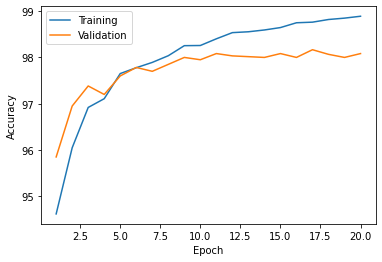

In [27]:
import numpy as np
num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1),
train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1),
valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()